<a href="https://colab.research.google.com/github/18521509/CS115/blob/main/CS115_MI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pytorch network

In [1]:
import numpy as np
import torch
import os
import sys
import tqdm
from torch import nn
import scipy.io as sio
from multiprocessing import cpu_count
from joblib import Parallel, delayed
import warnings
import numba
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib

def load_tishby_toy_dataset(filename, assign_random_labels=False, seed=42):

    np.random.seed(seed)
    data = sio.loadmat(filename)
    F = data['F']
    if assign_random_labels:
        y = np.random.randint(0, 2)
    else:
        y = data['y'].T
    return F, y


class BatchGenerator():
    def __init__(self, inputs_list, batch_size, seed=None):
        self.inputs_list = inputs_list
        self.batch_size = batch_size
        self.seed = seed
    
        self.indices = np.arange(self.inputs_list[0].shape[0])
        np.random.seed(self.seed)   
        np.random.shuffle(self.indices)

    def how_it_shuffled(self):
        return [current_input[self.indices] for current_input in self.inputs_list], np.arange(len(self.indices))[self.indices]

    def batch_generator(self):
        assert(len(self.inputs_list) > 0)
        
        
        for input_array in self.inputs_list:
            assert(input_array.shape[0] == self.inputs_list[0].shape[0])
            
        data_size = self.inputs_list[0].shape[0] // self.batch_size
        
        if self.inputs_list[0].shape[0] % self.batch_size > 0:
            data_size += 1
            
        for i in range(0, data_size):
            current_indices = self.indices[i * self.batch_size: (i + 1) * self.batch_size]     
            yield [current_input[current_indices] for current_input in self.inputs_list]


class MLPWithInfo(nn.Module):
    def __init__(self, input_dim=12, layers_dim=[10, 7, 5, 4, 3, 1], 
                 activation=nn.Tanh, output_activation=nn.Sigmoid, last_activation=nn.Sigmoid):
        super().__init__()
        self.representations_per_epochs = []
        self.info_layers_numbers = []
        layers_dims = [input_dim] + layers_dim
        self.has_output_activation = output_activation is not None
        self.last_activation = last_activation

        layers = []
        
        current_layer = -1
        for i in range(len(layers_dims) - 1):
            if i != len(layers_dims) - 2: 
                layers += [nn.Linear(layers_dims[i], layers_dims[i + 1]), activation()]
                current_layer += 2

                self.info_layers_numbers.append(current_layer)
            else:
                layers += [nn.Linear(layers_dims[i], layers_dims[i + 1])]
                if output_activation is not None:
                    layers += [output_activation()]

                current_layer += 2
                self.info_layers_numbers.append(current_layer)
                 
        self.model = nn.ModuleList(layers)
        self.current_representations = None
        self.reset()
        
    def forward(self, x):
        """
        Assume that the model's layers are structured as follows:
            Linear -> activation -> Linear -> ... -> activation.
        Thus we keep every other output.
        """
        # ws_epoch = []
        current_representation = x

        # self.add_info(0, x.detach().numpy())
        next_layer_index = 0

        for i, layer in enumerate(self.model):
            current_representation = layer(current_representation)

            if i == self.info_layers_numbers[next_layer_index]:
                self.add_info(next_layer_index, current_representation.detach().numpy())
                next_layer_index += 1

        if not self.has_output_activation:
            self.add_info(next_layer_index, self.last_activation()(current_representation).detach().numpy())
        else:
            self.add_info(next_layer_index, current_representation.detach().numpy())
        # assert(len(ws_epoch) == len(self.model))
        # self.representations += ws_epoch

        return current_representation

    def next_epoch(self):
        self.representations_per_epochs.append(self.current_representations)
        self.reset()

    def add_info(self, layer_index, representations):
        if self.current_representations[layer_index] is None:
            self.current_representations[layer_index] = representations
        else:
            self.current_representations[layer_index] = np.concatenate([self.current_representations[layer_index],
                                                                       representations], axis=0)
    def reset(self):
        self.current_representations = [None for _ in range(len(self.info_layers_numbers))]
        # self.representations_epochs = []


def train_network(model, X, y, X_val, y_val, batch_size=12, epochs=16):
    """
    The network is trained with full batch
    """
    loss_list = []
    epoch_mean_loss = []
    accuracy_mean_val = []
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
    loss_fun = nn.BCEWithLogitsLoss()
    model.reset()
    train_shuffles = []

    for epoch in tqdm.tqdm(range(epochs)):
        samples = 0
        cum_loss = 0

        model.reset()

        train_batcher = BatchGenerator([X, y], batch_size)
        train_shuffles.append(train_batcher.how_it_shuffled()[1])

        for X_batch, y_batch in train_batcher.batch_generator():
            X_batch = torch.Tensor(X_batch)
            y_batch = torch.Tensor(y_batch)

            model.train()
            predictions = model(X_batch)

            loss = loss_fun(predictions.reshape(-1), y_batch.reshape(-1))
            loss.backward()

            loss_list.append(loss.item())

            optimizer.step()
            optimizer.zero_grad()

            samples += X_batch.shape[0]
            cum_loss += loss.item()

        scheduler.step()
        model.next_epoch()

        epoch_mean_loss.append(cum_loss / samples)

        samples_val = 0
        accuracy_val = 0

        val_batcher = BatchGenerator([X_val, y_val], 1)

        for X_batch, y_batch in val_batcher.batch_generator():
            X_batch = torch.Tensor(X_batch)
            y_batch = torch.Tensor(y_batch)

            model.eval()
            predictions_logits = model(X_batch)

            accuracy_val += (y_batch.int() == (torch.nn.functional.sigmoid(predictions_logits) > 0.5).int()).sum().item()
            samples_val += X_batch.shape[0]

        accuracy_mean_val.append(float(accuracy_val) / samples_val)

    return epoch_mean_loss, accuracy_mean_val, train_shuffles


# def train_network_non_robus(model, X, y, X_val, y_val, epochs=16):
#     """
#     The network is trained with full batch
#     """

#     batch_size = X.shape[0]
#     loss_list = []
#     epoch_mean_loss = []
#     accuracy_mean_val = []
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     loss_fun_nonrobust = torch.nn.BCELoss()
#     model.reset()
    
#     for epoch in tqdm.tqdm(range(epochs)):
#         samples = 0
#         cum_loss = 0

#         model.reset()

#         for X_batch, y_batch in pytorch_network.batch_generator([X, y], batch_size):
#             X_batch = torch.Tensor(X_batch)
#             y_batch = torch.Tensor(y_batch)

#             model.train()
#             predictions = model(X_batch)

#             loss = loss_fun_nonrobust(predictions.reshape(-1), y_batch.reshape(-1))
#             loss.backward()

#             loss_list.append(loss.item())

#             optimizer.step()
#             optimizer.zero_grad()

#             samples += X_batch.shape[0]
#             cum_loss += loss.item()

#         model.next_epoch()

#         epoch_mean_loss.append(cum_loss / samples)

#         samples_val = 0
#         accuracy_val = 0

#         for X_batch, y_batch in pytorch_network.batch_generator([X_val, y_val], 1):
#             X_batch = torch.Tensor(X_batch)
#             y_batch = torch.Tensor(y_batch)

#             model.eval()
#             predictions_logits = model(X_batch)

#             accuracy_val += (y_batch.int() == (predictions_logits > 0.5).int()).sum().item()
#             samples_val += X_batch.shape[0]

#         accuracy_mean_val.append(float(accuracy_val) / samples_val)

#     return epoch_mean_loss, accuracy_mean_val

# nonrobust_train = train_network_non_robus(non_robust_model, X_train, y_train.astype(np.int),
#                                           X_test, y_test.astype(np.int), epochs)

# ws_nonron = non_robust_model.representations_epochs


#information process

In [2]:
"""
Calculate the information in the network
"""


NUM_CORES = cpu_count()
warnings.filterwarnings("ignore")


@numba.jit
def entropy(probs):
    return -np.sum(probs * np.ma.log2(probs))


@numba.jit
def joint_entropy(unique_inverse_x, unique_inverse_y, bins_x, bins_y):

    joint_distribution = np.zeros((bins_x, bins_y))
    np.add.at(joint_distribution, (unique_inverse_x, unique_inverse_y), 1)
    joint_distribution /= np.sum(joint_distribution)

    return entropy(joint_distribution)


@numba.jit
def layer_information(layer_output, bins, py, px, unique_inverse_x, unique_inverse_y):
    ws_epoch_layer_bins = bins[np.digitize(layer_output, bins) - 1]
    ws_epoch_layer_bins = ws_epoch_layer_bins.reshape(len(layer_output), -1)
    unique_t, unique_inverse_t, unique_counts_t = np.unique(
        ws_epoch_layer_bins, axis=0,
        return_index=False, return_inverse=True, return_counts=True
    )
    pt = unique_counts_t / np.sum(unique_counts_t)

    # # I(X, Y) = H(Y) - H(Y|X)
    # # H(Y|X) = H(X, Y) - H(X)

    x_entropy = entropy(px)
    y_entropy = entropy(py)
    t_entropy = entropy(pt)
    x_t_joint_entropy = joint_entropy(unique_inverse_x, unique_inverse_t, px.shape[0], layer_output.shape[0])
    y_t_joint_entropy = joint_entropy(unique_inverse_y, unique_inverse_t, py.shape[0], layer_output.shape[0])
    return {
        'local_IXT': t_entropy + x_entropy - x_t_joint_entropy,
        'local_ITY': y_entropy + t_entropy - y_t_joint_entropy
    }

@numba.jit
def calc_information_for_epoch(epoch_number, ws_epoch, bins, unique_inverse_x,
                               unique_inverse_y, pxs, pys):
    """Calculate the information for all the layers for specific epoch"""
    information_epoch = []

    for i in range(len(ws_epoch)):
        information_epoch_layer = layer_information(
            layer_output=ws_epoch[i],
            bins=bins,
            unique_inverse_x=unique_inverse_x,
            unique_inverse_y=unique_inverse_y,
            px=pxs, py=pys
        )
        information_epoch.append(information_epoch_layer)
    information_epoch = np.array(information_epoch)

    # print('Processed epoch {}'.format(epoch_number))

    return information_epoch


@numba.jit
def extract_probs(label, x):
    """calculate the probabilities of the given data and labels p(x), p(y) and (y|x)"""
    pys = np.sum(label, axis=0) / float(label.shape[0])

    unique_x, unique_x_indices, unique_inverse_x, unique_x_counts = np.unique(
        x, axis=0,
        return_index=True, return_inverse=True, return_counts=True
    )

    pxs = unique_x_counts / np.sum(unique_x_counts)

    unique_array_y, unique_y_indices, unique_inverse_y, unique_y_counts = np.unique(
        label, axis=0,
        return_index=True, return_inverse=True, return_counts=True
    )
    return pys, None, unique_x, unique_inverse_x, unique_inverse_y, pxs




##get_information 

In [3]:
def get_information(ws, x, label, num_of_bins, every_n=1,
                    return_matrices=False):
    """
    Calculate the information for the network for all the epochs and all the layers

    ws.shape =  [n_epoch, n_layers, n_params]
    ws --- outputs of all layers for all epochs
    """

    # print('Start calculating the information...')

    bins = np.linspace(-1, 1, num_of_bins)
    label = np.array(label).astype(np.float)
    pys, _, unique_x, unique_inverse_x, unique_inverse_y, pxs = extract_probs(label, x)

    with Parallel(n_jobs=NUM_CORES, prefer='threads') as parallel:
        information_total = parallel(
            delayed(calc_information_for_epoch)(
                i, epoch_output, bins, unique_inverse_x, unique_inverse_y, pxs, pys
            ) for i, epoch_output in enumerate(ws) if i % every_n == 0
        )
    if not return_matrices:
        return information_total

    ixt_matrix = np.zeros((len(information_total), len(ws[0])))
    ity_matrix = np.zeros((len(information_total), len(ws[0])))

    for epoch, layer_info in enumerate(information_total):
        for layer, info in enumerate(layer_info):
            ixt_matrix[epoch][layer] = info['local_IXT']
            ity_matrix[epoch][layer] = info['local_ITY']

    return ixt_matrix, ity_matrix

#plot information

In [4]:

def get_aligned_representations(representations, order):
    for epoch in range(len(representations)):
        for layer in range(len(representations[0])):
            representations[epoch][layer] = representations[epoch][layer][np.argsort(order[epoch]), :]

    return representations


#experiments

In [5]:
model = MLPWithInfo(output_activation=None)

In [6]:
model

MLPWithInfo(
  (model): ModuleList(
    (0): Linear(in_features=12, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=7, bias=True)
    (3): Tanh()
    (4): Linear(in_features=7, out_features=5, bias=True)
    (5): Tanh()
    (6): Linear(in_features=5, out_features=4, bias=True)
    (7): Tanh()
    (8): Linear(in_features=4, out_features=3, bias=True)
    (9): Tanh()
    (10): Linear(in_features=3, out_features=1, bias=True)
  )
)

In [7]:
model.info_layers_numbers

[1, 3, 5, 7, 9, 11]

In [8]:
X, y = load_tishby_toy_dataset('/content/drive/My Drive/Datasets/information_bottleneck_pytorch/g1.mat')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.9)

In [9]:
epochs = 100
train_res = train_network(model, X_train, y_train.astype(np.int),
                                          X_test, y_test.astype(np.int), batch_size=12, epochs=epochs)

100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


In [10]:
ws = model.representations_per_epochs
order = train_res[2]

ws = get_aligned_representations(ws, order)

In [11]:
assert len(model.representations_per_epochs) == epochs
assert len(model.representations_per_epochs[0]) == len(model.info_layers_numbers)

for i in range(len(model.representations_per_epochs[0])):
    assert(model.representations_per_epochs[0][i].shape[0] == X_train.shape[0])

In [12]:
# plt.plot(np.arange(len(train_res[0])), train_res[0])

In [13]:
# plt.plot(np.arange(len(train_res[1])), train_res[1])

In [16]:
num_of_bins = 40
every_n = 10
IXT_array, ITY_array = get_information(ws, X_train, np.concatenate([y_train, 1 - y_train], axis=1), 
                                       num_of_bins, every_n=1, return_matrices=True)


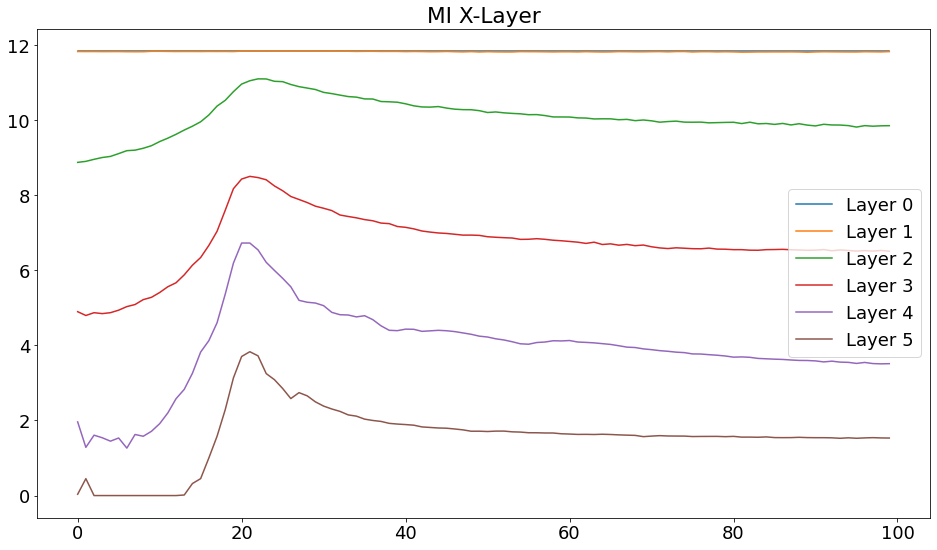

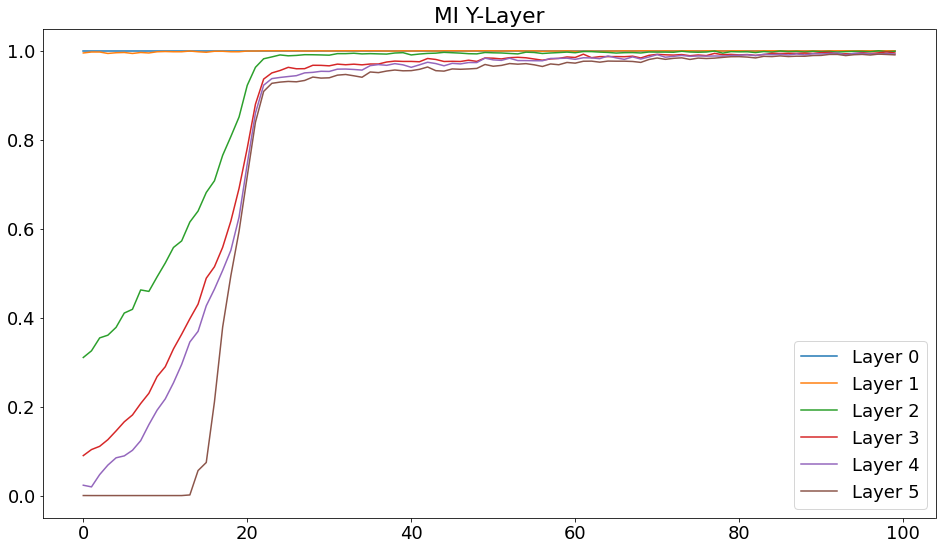

In [22]:
from matplotlib import pyplot as plt
plt.figure(figsize = (16,9))
plt.title('MI X-Layer')
for layer in range(6):
    plt.plot(IXT_array[:,layer],label = f'Layer {layer}')
plt.legend()
plt.show()
plt.figure(figsize = (16,9))
plt.title('MI Y-Layer')
for layer in range(6):
    plt.plot(ITY_array[:,layer],label = f'Layer {layer}')
plt.legend()
plt.show()